### 구현 모델 : 현재 온도, 습도, 재실인원에 따른 에어컨 ON/OFF 여부 판별 AI 모델
<small>
    <p>사용할 센서 : 실외 온도, 실외 습도, 실내 온도, 실내 습도, 재실인원, 에어컨 ON/OFF여부 판별 도어 센서</p>
    <p>구현 방식 : 시간에 따른 환경 정보와 에어컨 ON/OFF 상태를 지도학습으로 학습시켜 일반적으로 사용하는 에어컨 ON/OFF 기준을 학습하고 실시간으로 에어컨을 자동 제어하도록 함.</p>
    <p>AI 모델 사용 시 이점 : 사용자의 평소 패턴을 바탕으로 에어컨을 자동제어하기 때문에 편의성 증가 및 쾌적한 환경에서 생활 가능.</p>
</small>

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from influxdb_client import InfluxDBClient
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np
import os


### &#127991; 데이터 수집
<small>
    <p> InfluxDB에 접속하여 필요한 센서 데이터 가져오기 </p>
</small>

In [8]:
# InfluxDB 접속 정보 불러오기
load_dotenv()

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [9]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 14d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (1977, 10)
outdoor humidity shape:  (1975, 10)
class_a temperature shape:  (53795, 10)
class_a humidity shape:  (53800, 10)
class_a total_people_count shape:  (39971, 10)
class_a magnet_status shape:  (2043, 10)


### &#127991; 데이터 전처리
<small>
    <p> 필요없는 컬럼 삭제 및 한국시간대로 시간대 변환, 주말 데이터는 매우 불규칙하므로 삭제 </p>
    <p> 결측치 처리 </p>
</small>

In [10]:
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    df = df[df['_time'].dt.dayofweek < 5]
    return df

temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [11]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-05-09 09:02:00    15.5
2024-05-09 09:03:00     NaN
2024-05-09 09:04:00     NaN
2024-05-09 09:05:00     NaN
2024-05-09 09:06:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-05-09 09:02:00    60.0
2024-05-09 09:03:00     NaN
2024-05-09 09:04:00     NaN
2024-05-09 09:05:00     NaN
2024-05-09 09:06:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-05-09 09:00:00    22.533333
2024-05-09 09:01:00    22.800000
2024-05-09 09:02:00    22.500000
2024-05-09 09:03:00    22.750000
2024-05-09 09:04:00    22.600000
Freq: T, Name: value, dtype: float64 
 _time
2024-05-09 09:00:00    43.166667
2024-05-09 09:01:00    41.750000
2024-05-09 09:02:00    43.166667
2024-05-09 09:03:00    41.750000
2024-05-09 09:04:00    43.333333
Freq: T, Name: value, dtype: float64 
 _time
2024-05-09 09:00:00    5.0
2024-05-09 09:01:00    7.0
2024-05-09 09:02:00    5.0
2024-05-09 09:03:00    7.0
2024-05-09 09:04:00    7.0
Freq: T, Name: value, dtype: float64 
 _time
2024-05-09 09:08:00    c

In [12]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df.info)

<bound method DataFrame.info of                      outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-05-09 09:00:00                  NaN               NaN    22.533333   
2024-05-09 09:01:00                  NaN               NaN    22.800000   
2024-05-09 09:02:00            15.500000              60.0    22.500000   
2024-05-09 09:03:00                  NaN               NaN    22.750000   
2024-05-09 09:04:00                  NaN               NaN    22.600000   
...                                  ...               ...          ...   
2024-05-23 22:39:00                  NaN               NaN    23.150000   
2024-05-23 22:40:00                  NaN               NaN    22.766666   
2024-05-23 22:41:00            24.799999              61.5    23.150000   
2024-05-23 22:42:00                  NaN               NaN    22.833333   
2024-05-23 22:43:00                  NaN               NaN          

In [13]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df['air_conditional'].iloc[0]):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

# 실내외 온도 및 습도 컬럼의 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
def fill_first_missing_with_first_valid(data_df, column):
    if pd.isna(data_df[column].iloc[0]):
        notnull_value = data_df[data_df[column].notnull()].iloc[0][column]
        data_df.at[data_df.index[0], column] = notnull_value

columns_to_fill = ['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count']
for column in columns_to_fill:
    fill_first_missing_with_first_valid(data_df, column)

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)
print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 outdoor_temperature    19581
outdoor_humidity       19583
temperature             5763
humidity                5763
people_count            6832
air_conditional        19546
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64


In [14]:
# 복사본 생성
data_df_filter_by_environment = data_df_filled.copy()
data_df_filter_by_time = data_df_filled.copy()

<h5> 환경에 따른 에어컨 사용량 분석을 위한 전처리</h5>
<small>
    <p>- 시간과 환경에 따른 정보를 봐야하므로 날짜값제거, 시간 정보만 사용</p>
    <p>- datetime 객체는 분석을 위해 수치형 데이터로 변환 필요. -> 자정으로부터 경과한 분으로 변환 ex.02시 -> 120분</p>
    <p>- air_conditional 컬럼값의 타입이 String이므로 데이터분석을 위해 수치형 데이터로 변환 필요. close면 0, open이면 1로 변경</p>
    <p>- 상관계수 확인</p>
    <p>- 변수간 다중공선성 진단</p>
</small>

In [15]:
# 날짜값 제거
data_df_filter_by_environment.index = data_df_filter_by_environment.index.time
print(data_df_filter_by_environment.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00                 15.5              60.0    22.533333  43.166667   
09:01:00                 15.5              60.0    22.800000  41.750000   
09:02:00                 15.5              60.0    22.500000  43.166667   
09:03:00                 15.5              60.0    22.750000  41.750000   
09:04:00                 15.5              60.0    22.600000  43.333333   

          people_count air_conditional  
09:00:00           5.0           close  
09:01:00           7.0           close  
09:02:00           5.0           close  
09:03:00           7.0           close  
09:04:00           7.0           close  


In [16]:
# 자정으로부터 경과한 분을 계산하기 위한 처리
data_df_filter_by_environment['time'] = data_df_filter_by_environment.index

# 'time' 컬럼의 datetime.time 객체를 분으로 변환하는 함수
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# 'time' 컬럼을 하루 중 분으로 변환
data_df_filter_by_environment['time_in_minutes'] = data_df_filter_by_environment['time'].apply(time_to_minutes)
data_df_filter_by_environment = data_df_filter_by_environment.drop(columns=['time'])

In [17]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_environment['air_conditional'] = data_df_filter_by_environment['air_conditional'].map({'close': 0, 'open': 1})
print(data_df_filter_by_environment.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00                 15.5              60.0    22.533333  43.166667   
09:01:00                 15.5              60.0    22.800000  41.750000   
09:02:00                 15.5              60.0    22.500000  43.166667   
09:03:00                 15.5              60.0    22.750000  41.750000   
09:04:00                 15.5              60.0    22.600000  43.333333   

          people_count  air_conditional  time_in_minutes  
09:00:00           5.0                0              540  
09:01:00           7.0                0              541  
09:02:00           5.0                0              542  
09:03:00           7.0                0              543  
09:04:00           7.0                0              544  


In [18]:
# 내외부 온도, 습도, 사람수에 따른 상관계수 계산
correlation_matrix = data_df_filter_by_environment.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.359032     0.399174   
outdoor_humidity               -0.359032          1.000000    -0.186973   
temperature                     0.399174         -0.186973     1.000000   
humidity                        0.149185          0.673141     0.058315   
people_count                    0.349002         -0.417752     0.478583   
air_conditional                 0.485565         -0.179838     0.055469   
time_in_minutes                 0.379320         -0.189782     0.114262   

                     humidity  people_count  air_conditional  time_in_minutes  
outdoor_temperature  0.149185      0.349002         0.485565         0.379320  
outdoor_humidity     0.673141     -0.417752        -0.179838        -0.189782  
temperature          0.058315      0.478583         0.055469         0.114262  
humidity             1.000000     -0.041033         0.079691        -0.047341  

<h5>&#128161; 상관계수 분석 결과</h5>
<small>
    <p>- 상관계수 : 두 변수 사이의 통계적 관계를 표현하기 위해 특정한 상관 관계의 정도를 수치적으로 나타낸 계수. 1에 가까울 수록 양의 관계가 강하고, -1에 가까울 수록 음의 관계가 강하며 0에 가까우면 아무런 관계가 없을 가능성이 높음.</p>
    <p>- 실외온도와 실내온도, 실내온도와 실내습도는 강한 양의 상관관계가 있음. 하지만 인원, 에어컨 작동여부에 따라 인과관계에 의해 수치가 변동할 수 있음.</p>
    <p>- 외부 온도, 외부 습도와 에어컨 작동에는 약간의 상관관계가 있음. 따라서 외부 온도와 외부 습도가 늘어날수록 에어컨 사용이 증가할 수 있음.</p>
    <p>- 인원수와 에어컨 사용에는 강한 양의 상관관계를 가짐. 따라서 인원이 많아질수록 에어컨 사용이 증가할 수 있음.</p>
</small>

In [19]:
# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = data_df_filter_by_environment.columns
vif_data["VIF"] = [variance_inflation_factor(data_df_filter_by_environment.to_numpy(), i) for i in range(data_df_filter_by_environment.shape[1])]

print(vif_data)

               feature         VIF
0  outdoor_temperature  266.546078
1     outdoor_humidity   86.274501
2          temperature  259.273442
3             humidity  359.916349
4         people_count    2.306538
5      air_conditional    4.300597
6      time_in_minutes    5.247439


<h5>&#128161;다중공선성 진단 결과</h5>
<small>
    - 다중공선성 : 독립변수간 상관관계가 보이는 것. 다중공선성이 있으면 부정확한 회귀결과가 도출될 확률이 높음.</p>
    - VIF(Variance Inflation Factors, 분산팽창요인) 값이 10 이상이면 해당 변수가 다른 독립변수들과 높은 상관관계를 가지고 있어 다중공선성이 존재할 가능성이 높다고 판단. 5가 넘의면 주의할 필요가 있는 것으로 판단.</p>
    <p>- 다중공선성이 높으면 회귀분석 모델에서 독립변수 간의 강한 상관관계 때문에 모델의 계수 추정치가 불안정하게 되어 모델 예측에 부정적인 영향을 끼칠 수 있음. 따라서 회귀모델에서는 높은 다중공선성을 가진 컬럼중 일부를 삭제하거나 변형하여 학습하는 것이 좋음.</p>
    <p>- 실제로 회귀모델에서 제거전에는 0.90, 제거 후에는 0.92로 성능이 소폭 향상됨. 하지만 실내온도와 실내습도를 제거하지 않고 계속 포함시키도록 결정함. 실내온도와 실내습도는 다른 독립변수(외부온도, 외부습도, 재실인원)와 종속변수(에어컨 ON/OFF)에 모두 영향을 미치기 때문에 이 변수들을 모델에서 제외하면 다른 변수들의 영향을 올바르게 추정하지 못 할 수 있음. 또한, 실내온도와 실내습도는 에어컨의 작동 여부를 결정하는 데 실제로 중요한 변수임. 이 변수들을 제외하면 모델이 실제 상황을 반영하는 데 있어서 현실적인 해석력을 잃을 수 있음. 우리 모델의 목적은 단순히 예측 성능을 극대화하는 것이 아니라 실제 운영 환경에서 의사 결정을 지원하기 위해서이므로 실내온도와 실내습도 데이터를 제외하지 않는 것으로 결정.</p>
</small>

<h5>시간에 따른 에어컨 사용량 분석을 위한 전처리</h5>
<small>
    <p>- air_conditional 컬럼의 데이터분석을 위해 수치형 데이터로 변환 필요. close면 0, open이면 1로 변경</p>
    <p>- 날짜값제거, 시간 정보만 사용</p>
    <p>- datetime 객체를 분석을 위해 수치형 데이터로 변환 필요. -> 자정으로부터 경과한 분으로 변환</p>
    <p>- air_conditional 컬럼의 값을 30분을 기준으로 그룹화하여 30분당 평균 에어컨 사용 확률을 나타냄.</p>
</small>

In [20]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_time['air_conditional'] = data_df_filter_by_time['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filter_by_time.head())

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-05-09 09:00:00                 15.5              60.0    22.533333   
2024-05-09 09:01:00                 15.5              60.0    22.800000   
2024-05-09 09:02:00                 15.5              60.0    22.500000   
2024-05-09 09:03:00                 15.5              60.0    22.750000   
2024-05-09 09:04:00                 15.5              60.0    22.600000   

                      humidity  people_count  air_conditional  
_time                                                          
2024-05-09 09:00:00  43.166667           5.0                0  
2024-05-09 09:01:00  41.750000           7.0                0  
2024-05-09 09:02:00  43.166667           5.0                0  
2024-05-09 09:03:00  41.750000           7.0                0  
2024-05-09 09:04:00  43.333333           7.0                0  


In [21]:
# 30분 평균 에어컨 온도 사용량
data_df_filter_by_time = data_df_filter_by_time.drop(columns=['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count'])
data_df_filter_by_time['air_conditional'].resample('30T').mean()

# 날짜를 제외하고 시간 인덱스에서 시간 부분만 추출
times_only = data_df_filter_by_time['air_conditional'].resample('30T').mean().index.time

# 시간을 DataFrame의 새 인덱스로 설정
resampled_data = data_df_filter_by_time['air_conditional'].resample('30T').mean()
resampled_data.index = times_only

# 시간을 기준으로 그룹화하고 각 그룹의 평균을 계산
grouped_by_time = resampled_data.groupby(resampled_data.index).mean()

print(grouped_by_time.tail())

21:30:00    0.866667
22:00:00    0.866667
22:30:00    0.866667
23:00:00    0.833333
23:30:00    0.735714
Name: air_conditional, dtype: float64


### &#127991; 데이터 시각화

<h5>환경에 따른 에어컨 사용량 분석</h5>

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


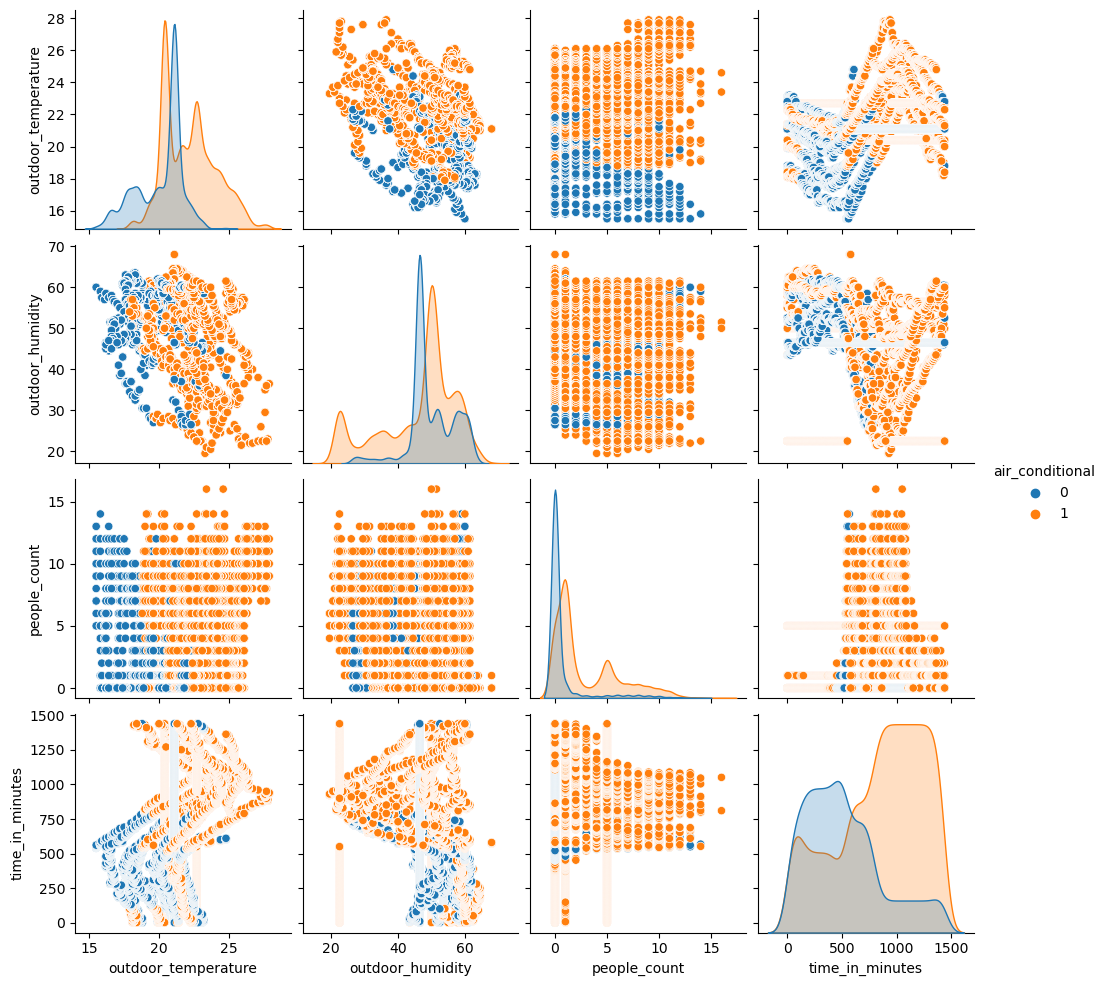

In [22]:
# 산점도 그리기
sns.pairplot(data_df_filter_by_environment, hue='air_conditional', vars=['outdoor_temperature', 'outdoor_humidity', 'people_count', 'time_in_minutes'])
plt.show()

<h5>&#128161; 환경에 따른 에어컨 사용량 산점도 분석 결과</h5>
<p>- 외부온도와 재실인원, 외부습도와 재실인원에 따른 에어컨 ON/OFF가 일정한 경향을 보임. 따라서 외부온도, 외부습도, 재실인원에 따른 에어컨 ON/OFF를 시각화 해보도록 함.</p>

In [23]:
plt_df = data_df_filter_by_environment

/home/gahyoung/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


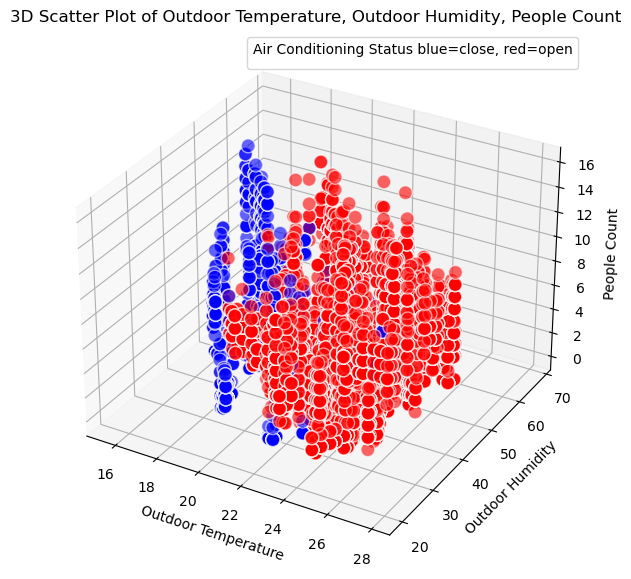

In [24]:
# 외부온도, 외부습도와 재실인원에 따른 에어컨 ON/OFF 경향
# 3D 산점도 생성
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 색상 맵 설정
colors = {0: 'blue', 1: 'red'}

# 산점도 플롯
scatter = ax.scatter(plt_df['outdoor_temperature'], plt_df['outdoor_humidity'] , plt_df['people_count'],
                     c=plt_df['air_conditional'].apply(lambda x: colors[x]),
                     marker='o', s=100, alpha=0.6, edgecolors='w')

# 축 라벨
ax.set_xlabel('Outdoor Temperature')
ax.set_zlabel('People Count')
ax.set_ylabel('Outdoor Humidity')

# 범례 추가
ax.legend(*scatter.legend_elements(), title="Air Conditioning Status blue=close, red=open")

plt.title('3D Scatter Plot of Outdoor Temperature, Outdoor Humidity, People Count')
plt.show()

<h5> 축 설명 </h5>
<small>
    <p>X축 (외부 온도): 16도에서 22도 사이의 값을 가집니다. 에어컨 사용과 관련하여 실외 온도의 영향을 나타내며, 온도가 높을수록 실내로의 열 부하가 증가하여 에어컨을 켤 가능성이 높아집니다.</p>
    <p>Y축 (외부 습도): 40에서 75까지의 범위를 가집니다. 에어컨 사용과 관련하여 실외 습도의 영향을 나타내며, 습도가 높을 수록 에어컨을 켤 가능성이 높아집니다.</p>
    <p>Z축 (재실 인원 수): 0에서 16까지의 범위를 가집니다. 인원 수에 따른 에어컨 사용의 변화를 나타내며 인원 수는 실내 열 발생과 관련이 있어, 많은 사람들이 있는 공간은 더 빨리 더워지므로 에어컨을 켤 가능성이 높아집니다.</p>
    <p>마커: 0에서 1까지의 값을 가지며, 1은 에어컨이 켜져 있음을, 0은 꺼져 있음을 나타냅니다.</p>
    <h3>관찰 및 인사이트 </h3>
    <p>파란색 마커 (에어컨 OFF): 낮은 온도, 낮은 습도, 적은 인원 수일때 에어컨이 꺼져 있을 확률이 높음을 알 수 있습니다.</p>
    <p>빨간색 마커(에어컨 ON): 높은 온도, 높은 습도, 또는 많은 인원 수일떄 에어컨이 꺼져 있을 확률이 높음을 알 수 있습니다.</p>
</small>

<h5> &#128161; 환경에 따른 에어컨 사용량 3D 산점도 분석 결과 </h5>
<small>
    <p>- outdoor_temperature 또는 outdoor_humidity가 높을때 people_count가 함께 높을수록 에어컨을 키는 빈도가 늘어난다.</p>
</small>

<h5>시간에 따른 에어컨 사용량 분석</h5>

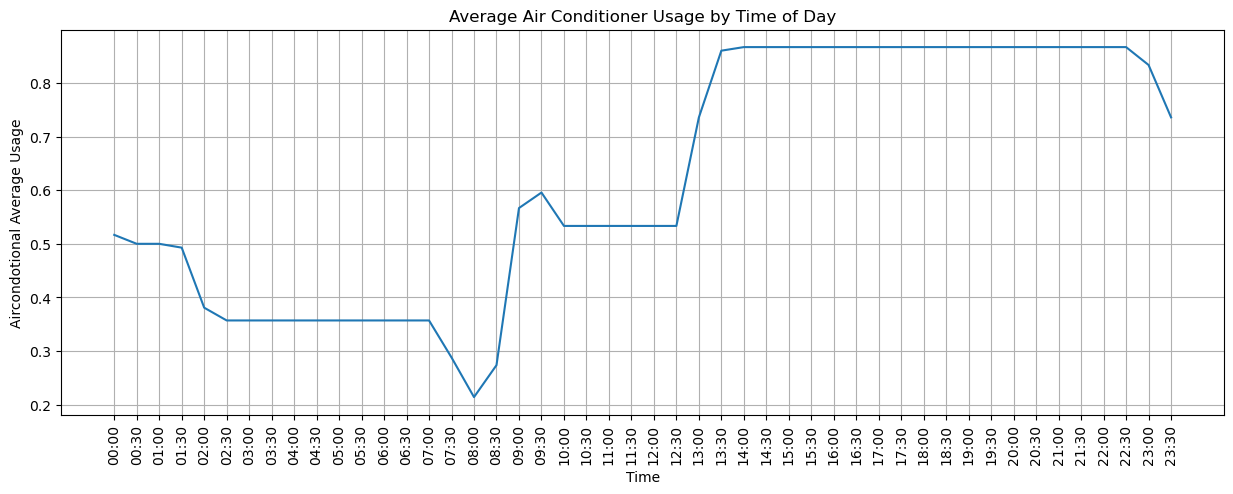

In [25]:
# grouped_by_time 인덱스를 하루 중 분으로 변환
minutes_since_midnight = [t.hour * 60 + t.minute for t in grouped_by_time.index]

# 데이터 시각화
fig, ax = plt.subplots(figsize=(15, 5))

# 선 그래프 그리기
ax.plot(minutes_since_midnight, grouped_by_time.values)

# 제목 및 라벨 설정
ax.set_title('Average Air Conditioner Usage by Time of Day')
ax.set_xlabel('Time')
ax.set_ylabel('Aircondotional Average Usage')

# x축 눈금 라벨 설정
# x축 눈금을 시간:분 형태로 표시
ax.set_xticks(minutes_since_midnight)  # 눈금 설정
ax.set_xticklabels([f'{t.hour:02}:{t.minute:02}' for t in grouped_by_time.index], rotation=90)

# 그리드 추가
ax.grid(True)

# 그래프 보여주기
plt.show()


<h5>&#128161; 시간에 따른 에어컨 사용량 그래프 분석 결과</h5>
<small>
    <p>- 학생들이 입실하는 오전 9시, 점심시간이후이 12시부터 에어컨 사용량이 늘어난다. 학원이 마치는 시간인 6시 이후부터는 사용량이 줄어들다가 12시 반 이후가 되면 에어컨이 꺼질 확률이 높다.</p>
</small>

### &#127991; 모델링
1. 데이터 분할

In [26]:
model_data_df =  data_df_filter_by_environment.copy()
print(model_data_df.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00                 15.5              60.0    22.533333  43.166667   
09:01:00                 15.5              60.0    22.800000  41.750000   
09:02:00                 15.5              60.0    22.500000  43.166667   
09:03:00                 15.5              60.0    22.750000  41.750000   
09:04:00                 15.5              60.0    22.600000  43.333333   

          people_count  air_conditional  time_in_minutes  
09:00:00           5.0                0              540  
09:01:00           7.0                0              541  
09:02:00           5.0                0              542  
09:03:00           7.0                0              543  
09:04:00           7.0                0              544  


In [27]:
# 훈련데이터와 테스트 데이터 분리
X = model_data_df[['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count', 'time_in_minutes']]
y = model_data_df['air_conditional']

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [28]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

# 모델 생성 및 학습
log_reg_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
log_reg_model.fit(X_train, y_train)

# 모델 평가
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [29]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [30]:
# XG 부스트
import xgboost as xgb

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [31]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.7936621396235406
RandomForest Accuracy: 0.9961877531570169
XGBoost Accuracy: 0.9959494877293305


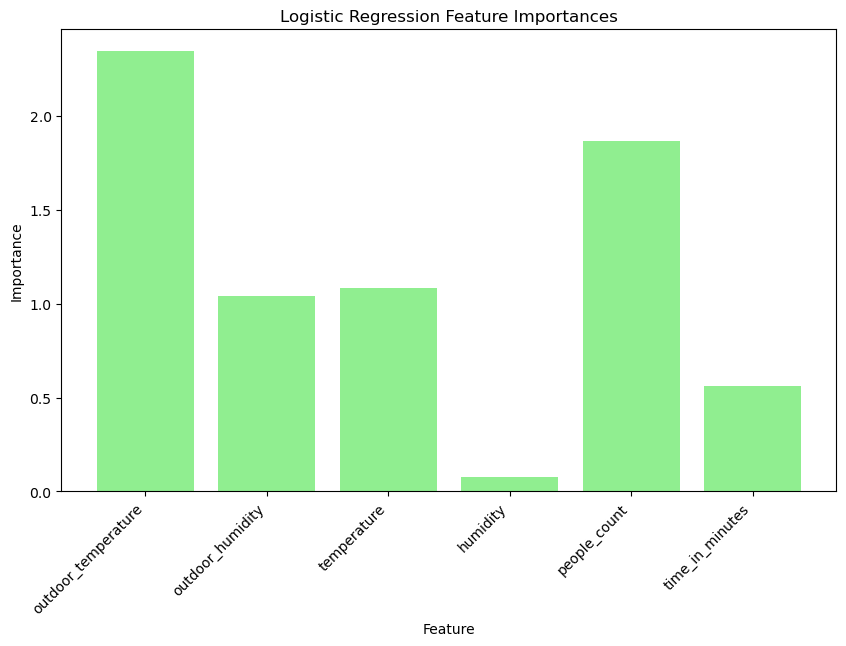

In [32]:
# LogisticRegression model 특성 중요도
# 로지스틱 회귀 모델의 계수 가져오기
coefficients = log_reg_model.named_steps['logisticregression'].coef_[0]

# 특성 이름
feature_names = X_train.columns

# 계수의 크기로 특성 중요도 계산
feature_importances_logreg = np.abs(coefficients)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_logreg)), feature_importances_logreg, tick_label=feature_names, color='lightgreen')
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()


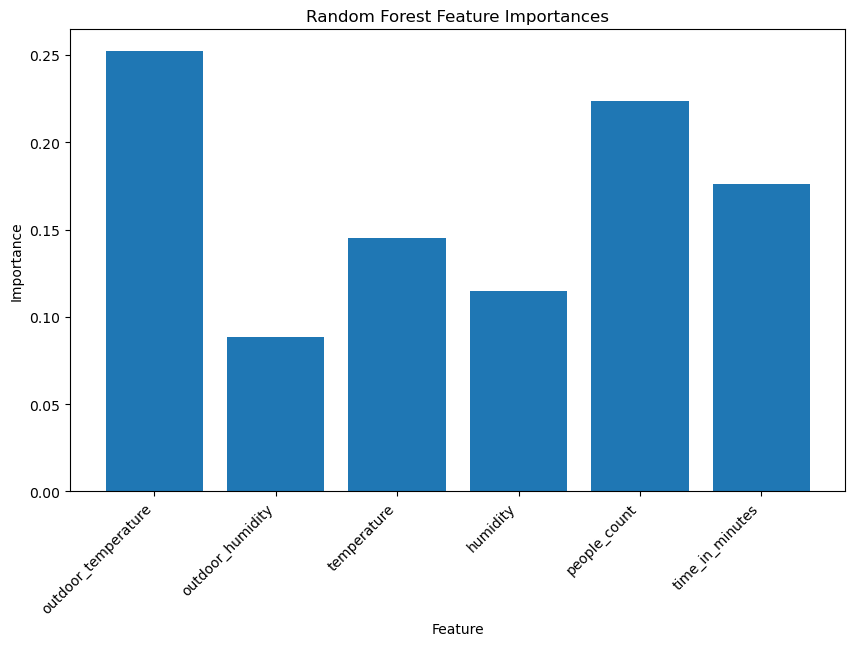

In [33]:
# RandomForest model 특성 중요도
feature_importances_rf = rf_model.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf, tick_label=X.columns)
plt.title('Random Forest Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

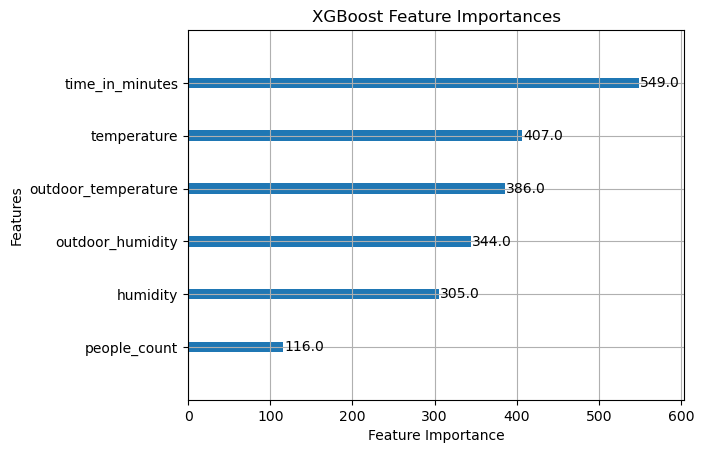

In [34]:
# XGBoost model 특성 중요도
from xgboost import plot_importance

plot_importance(xgboost_model, importance_type='weight')
plt.title('XGBoost Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

<h5>교차검증</h5>
<small>
    <p>교차검증 진행 이유 : 모델의 일반화 성능을 더 정확하게 평가하기 위해 교차 검증 (cross-validation) 진행.</p>
    <p>교차검증 방식 : 시계열 데이터를 검증할 때는 데이터 포인트 간의 시간적 종속성이 있기 때문에, 시간적 종속성을 무시하고 데이터를 무작위로 섞으면, 미래 데이터가 훈련 데이터에 포함될 수 있음. 따라서 TimeSeriesSplit을 사용하여 데이터를 k개의 연속적인 폴드로 나누고, 각 폴드에서 i번째 폴드는 i-1번째 폴드의 모든 데이터를 포함하게 함으로서 시간의 흐름에 따라 점진적으로 훈련 데이터를 확장하는 방식으로 검증하게 함.</p>
</small>

In [35]:
# 각 모델에 대해 교차 검증 실행
tscv = TimeSeriesSplit(n_splits=5)

def perform_cross_validation(model, X, y, cv):
    accuracy_scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
    
    return accuracy_scores

log_reg_scores = perform_cross_validation(log_reg_model, X, y, tscv)
rf_scores = perform_cross_validation(rf_model, X, y, tscv)
xgb_scores = perform_cross_validation(xgboost_model, X, y, tscv)
# 결과 출력
print("Logistic Regression CV Scores:", log_reg_scores)
print("Random Forest CV Scores:", rf_scores)
print("XGBoost CV Scores:", xgb_scores)

# 각 모델의 평균 정확도 계산
print("Average CV Accuracy - Logistic Regression: {:.2f}%".format(np.mean(log_reg_scores) * 100))
print("Average CV Accuracy - Random Forest: {:.2f}%".format(np.mean(rf_scores) * 100))
print("Average CV Accuracy - XGBoost: {:.2f}%".format(np.mean(xgb_scores) * 100))

Logistic Regression CV Scores: [0.9422362024592508, 0.7923934801258221, 0.5095796396911638, 0.5072919645410352, 0.9573920503288533]
Random Forest CV Scores: [0.8884758364312267, 0.7512153274235058, 0.7675150128681727, 0.7340577637975407, 0.885902201887332]
XGBoost CV Scores: [0.9113525879325136, 0.8155561910208751, 0.7740920789247927, 0.7363454389476695, 0.8238490134400915]
Average CV Accuracy - Logistic Regression: 74.18%
Average CV Accuracy - Random Forest: 80.54%
Average CV Accuracy - XGBoost: 81.22%


<h5>&#128161; 모델별 교차검증 결과</h5>
<small>
    <p>- 로지스틱 회귀 모델은 상당히 일관적인 분산을 보임. 하지만 Random Forest와 XGBoost 모델의 일부 폴드에서 100%의 정확도를 달성하거나 상당히 낮은 정확도를 보이는 등 일관성 없는 성능 분산을 보여줌.</p>
    <p>- 이러한 교차 검증 결과는 각 모델이 특정 데이터에 대해서는 과적합될 가능성이 있음을 시사함.</p>
</small>

- 방법 1. 하이퍼파라미터 튜닝을 통해 모델의 일관성을 높이고, 분산을 줄여서 모델의 안정성을 향상.
- 방법 2. 데이터 과적합 해결. 현재 데이터가 부족하므로 데이터가 쌓이는 것을 좀 더 기다림.

### &#127991;  하이퍼 파라미터 튜닝

1. 로지스틱 회귀

In [36]:
from sklearn.model_selection import GridSearchCV

# 파이프라인 생성
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# 튜닝할 파라미터 설정, 솔버 추가
# C: 정규화의 강도를 제어. 값이 작을수록 정규화가 강해짐.
# penalty: 정규화의 종류(l1, l2, elasticnet, none)를 지정. l1은 변수 선택의 효과가 있어 특성 선택에 유용할 수 있음.
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']  # liblinear와 saga는 l1 페널티 지원
}

# GridSearchCV 객체 생성, 에러 스코어 설정 변경
# Grid Search를 사용하여 다양한 C 값과 penalty 옵션을 조합해보고 교차 검증을 통해 최적의 조합을 찾음
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 성능 출력
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best cross-validation score: 0.80


In [37]:
# 최적의 파라미터를 사용하여 모델 생성
optimal_log_reg_model = make_pipeline(StandardScaler(), LogisticRegression(
    C=1, 
    penalty='l1', 
    solver='liblinear', 
    max_iter=1000
))

# 전체 훈련 데이터셋을 사용하여 모델 학습
optimal_log_reg_model.fit(X_train, y_train)

# 테스트 데이터셋에서 성능 평가
y_pred = optimal_log_reg_model.predict(X_test)
optimal_log_reg_accuracy = accuracy_score(y_test, y_pred)

print("optimal_log_reg_model Accuracy:", optimal_log_reg_accuracy)

optimal_log_reg_model Accuracy: 0.7936621396235406


2. 랜덤 포레스트

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# 파라미터 분포 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.3s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   5.8s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.4s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf

In [39]:
# 최적의 파라미터를 사용하여 모델 생성
optimal_rf_model = RandomForestClassifier(
    n_estimators=300, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_depth=None, 
    bootstrap=False,
    random_state=42
)

# 모델 학습
optimal_rf_model.fit(X_train, y_train)

# 테스트 데이터셋에서 성능 평가
y_pred = optimal_rf_model.predict(X_test)
optimal_rf_accuracy = accuracy_score(y_test, y_pred)

# 성능 출력
print("optimal_rf_model Accuracy:", optimal_rf_accuracy)

optimal_rf_model Accuracy: 0.9976173457231355


3. XGBoost

In [40]:
# 하이퍼파라미터 분포 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# XGBoost 모델 설정
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 랜덤 탐색 설정
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=5, verbose=2, random_state=42, n_jobs=-1)

# 랜덤 탐색 실행
random_search.fit(X_train, y_train)

# 최적의 파라미터와 성능 출력
print("Best parameters:", random_search.best_params_)
print("Best score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400; total time=   0.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=400; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.4s
[CV] END colsample_bytree=0.3,

In [41]:
# 최적의 파라미터를 사용하여 XGBoost 모델 생성
optimal_xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree=0.5,
    random_state=42
)

# 모델 학습
optimal_xgb_model.fit(X_train, y_train)

# 테스트 데이터셋에서 성능 평가
y_pred = optimal_xgb_model.predict(X_test)
optimal_xgb_model_accuracy = accuracy_score(y_test, y_pred)

# 성능 출력
print("optimal_xgb_model Accuracy:", optimal_xgb_model_accuracy)

optimal_xgb_model Accuracy: 0.9961877531570169


In [42]:
print('하이퍼 파라미터 튜닝 전')
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy, '\n')

print('하이퍼 파라미터 튜닝 후')
print("optimal_log_reg Accuracy:", optimal_log_reg_accuracy)
print("optimal_rf Accuracy:", optimal_rf_accuracy)
print("optimal_xgb_model Accuracy:", optimal_xgb_model_accuracy)

하이퍼 파라미터 튜닝 전
LogisticRegression Accuracy: 0.7936621396235406
RandomForest Accuracy: 0.9961877531570169
XGBoost Accuracy: 0.9959494877293305 

하이퍼 파라미터 튜닝 후
optimal_log_reg Accuracy: 0.7936621396235406
optimal_rf Accuracy: 0.9976173457231355
optimal_xgb_model Accuracy: 0.9961877531570169


In [43]:
tscv = TimeSeriesSplit(n_splits=5)

def perform_cross_validation(model, X, y, cv):
    accuracy_scores = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
    
    return accuracy_scores

# 각 모델에 대해 교차 검증 실행
optimal_log_reg_scores = perform_cross_validation(optimal_log_reg_model, X, y, tscv)
optimal_rf_scores = perform_cross_validation(optimal_rf_model, X, y, tscv)
optimal_xgb_scores = perform_cross_validation(optimal_xgb_model, X, y, tscv)

In [44]:
print("Logistic Regression CV Scores:", optimal_log_reg_scores)
print("Random Forest CV Scores:", optimal_rf_scores)
print("XGBoost CV Scores:", optimal_xgb_scores)

# 각 모델의 평균 정확도 계산
print("Average CV Accuracy - Logistic Regression: {:.2f}%".format(np.mean(log_reg_scores) * 100))
print("Average CV Accuracy - Random Forest: {:.2f}%".format(np.mean(rf_scores) * 100))
print("Average CV Accuracy - XGBoost: {:.2f}%".format(np.mean(xgb_scores) * 100))

Logistic Regression CV Scores: [0.9413783242779525, 0.7895338861881612, 0.5095796396911638, 0.5075779239348013, 0.9573920503288533]
Random Forest CV Scores: [0.8890477552187589, 0.7432084643980554, 0.7678009722619388, 0.7372033171289677, 0.845581927366314]
XGBoost CV Scores: [0.8907635115813555, 0.7452101801544181, 0.7915356019445239, 0.7460680583357163, 0.8770374606805833]
Average CV Accuracy - Logistic Regression: 74.18%
Average CV Accuracy - Random Forest: 80.54%
Average CV Accuracy - XGBoost: 81.22%


<h5>&#128161; 하이퍼 파라미터 튜닝 결과</h5>
<small>
    <p>- 로지스틱 회귀 모델은 하이퍼 파라미터 튜닝 후에도 안정적인 성능을 유지, 교차 검증에서도 높은 성능을 보임. 하지만 Random Fores와 XGBoost 모델은 여전히 일부 폴드에서 점수가 낮아짐. 따라서 특정 시점에서 모델이 예측을 잘 수행하지 못할 수 있음. 데이터가 적거나 훈련데이터에 과하게 맞춰져서 성능이 저하된 것으로 판단.</p> 
</small>

### &#127991; 모델 선택

In [62]:
# 테스트
data = pd.DataFrame({
    'outdoor_temperature' : [20],
    'outdoor_humidity' : [51],
    'temperature' : [22],
    'humidity' : [43],
    'people_count' : [2],
    'time_in_minutes' : [300]
})
rf_predictions = optimal_log_reg_model.predict(data)
print(rf_predictions)
rf_predictions = optimal_rf_model.predict(data)
print(rf_predictions)
xg_predictions = optimal_xgb_model.predict(data)
print(xg_predictions)


[1]
[1]
[1]
